In [1]:
from lib.controller import Controller
from lib.automation import FileDetector
from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.TSV import RegionExporter
from lib.file.pickle import Pickler
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.analysis.trace_sifter import TraceSifter, TraceLearner
from scipy import stats
import time
import os
import cv2
from lib.utilities import *

In [2]:
dir_base = "C:/Users/jjudge3/Desktop/Data/"
# dir_base = "C:/Users/jjudge3/Desktop/Data/Kate's/"
date = '10-14-22'
data_dir = dir_base + date +"/"
camera_program = 4

cre_line_type = None
quick_test = False

slice_target = [1,2]
rec_target = [i for i in range(0,13)] 
tbs_recording_no = 5
if date == '07-15-22':
    rec_target = [i for i in range(0,17)]  # 7/15
    tbs_recording_no = 5
if date == '07-22-22' and slice_target == 1:
    rec_target = [i for i in range(0,18)]  # 7/19
    tbs_recording_no = 4
if date == '07-22-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 5
if date == '07-26-22' and slice_target == 1:
    rec_target = [i for i in range(0,19)]  
    tbs_recording_no = 6
if date == '07-26-22' and slice_target == 2:
    rec_target = [i for i in range(0,16)]  
    tbs_recording_no = 4
if date == '08-01-22':
    slice_target = [1,2]
    rec_target = [i for i in range(11)]  
    tbs_recording_no = 4
if date == "11-30-21":
    rec_target = [2]
if date == "08-19-22":
    slice_target = [1,2]
    rec_target = [i for i in range(1,13)] 
if date == "08-22-22":
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(1,6)] 
if date == "09-01-22":
    slice_target = [i for i in range(5,8)]  # first 4: stim was 0
    rec_target = [i for i in range(0,7)] 
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre'
if date == "06-21-22":
    slice_target = [1,2,3]
    rec_target = [i for i in range(1,10)] 
    cre_line_type = 'ai35hVOS /PV-Cre'
if date == "10-14-22":
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(1,4)] 
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "2022-10-14": # anna's old rig data of same animal
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(1,4)]
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "10-21-22":
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(1,22)] 
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "2022-10-21": # anna's old rig data of same animal
    slice_target = [1,2,3,4,5,6]
    rec_target = [i for i in range(1,4)]
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "10-28-22":
    slice_target = [1,2,3]
    rec_target = [i for i in range(1,17)] 
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "2022-10-28": # anna's old rig data of same animal
    slice_target = [1,2,3,4,5]
    rec_target = [i for i in range(1,5)]
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "11-04-22":
    slice_target = [1,3,4]
    rec_target = [i for i in range(1,21)]
    tbs_recording_no = 11
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre'
if date == "2022-11-04": # anna's old rig data of same animal
    slice_target = [1,2,3,4,5]
    rec_target = [i for i in range(1,4)]
    cre_line_type = 'kv2.1hVOS 3.0 / PV-Cre' 
if date == "11-09-22":
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(4,21)]
    tbs_recording_no = 11
    cre_line_type = 'ai35hVOS / Scnn1a-tg3-Cre'
if date == "11-16-22":
    slice_target = [1,2,3,4]
    rec_target = [i for i in range(1,21)]
    tbs_recording_no = 11
    cre_line_type = 'ai35hVOS / Scnn1a-tg3-Cre'
if date == "11-23-22": # Kate's
    slice_target = [9]
    rec_target = [4]
    cre_line_type = 'ai35hVOS / PV-Cre'

load_dic = False
enable_alignment = False
align_only_first_rec = True  # instead of asking for a separate alignment for each recording
num_regions_to_export = 5  # max number of regions per record to export to PhotoZ
process_all = False  # overrides slice/rec target to process all files

# recording schedule
int_trial = 10
num_trial = 5
int_recording = 45
stim_times = 100  # pts
measure_window = [101, 121] # pts

actual_int_recording = int_trial * num_trial + int_recording

#cluster settings
sampling_size = 100000
if quick_test:
    sampling_size = 10000
k_cluster = 95  # set to None for AIC elbow plotting
# cluster filter settings
n_pixel_cutoff = 20  # maximum cluster size allowed
average_snr_cutoff_percentile = 50  # cluster-specific percentile

if quick_test:
    k_cluster = 5
    slice_target = [slice_target[0]]
    rec_target = rec_target[0:3]

# save time loading and clustering data by loading a saved run
save = True
restore_pickle = None  # saved run index to load, or None. 
save_pickle_index = 0  # save run index to save, or None. Will find higher index to avoid overwrite
if not save:  # then load
    restore_pickle, save_pickle_index = save_pickle_index, restore_pickle

In [3]:
# read in 8-bit single TIF images to array, apply same cropping/binning
single_images = {}
dic_dir = data_dir + "dic/"
cam_settings = CameraSettings().get_program_settings(camera_program)
binning = int(2048 / 400) # if want size similar to RLI

if load_dic and restore_pickle is None:
    TIFLoader(dic_dir, 
              cam_settings, 
              binning, 
              crop=False, 
              flip_horiz=True).load_files(single_images, slice_target=slice_target[0])
    try:
        print(list(single_images[slice_target[0]].values())[0]['i'].shape)
    except Exception as e:
        print("error", e)

slice 1 , rec 1


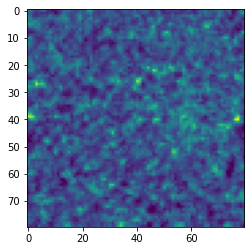

slice 1 , rec 2


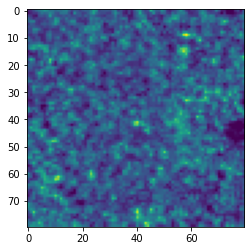

slice 1 , rec 3


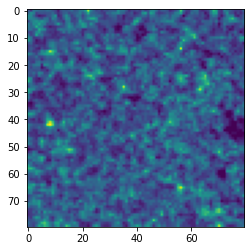

slice 2 , rec 1


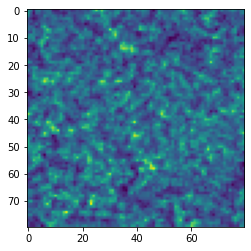

slice 2 , rec 2


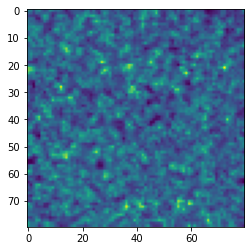

In [4]:
# read in non-normalized maps exported from PhotoZ: 
#  pre-stim SNR, stim SNR, RLI, and stim MaxAmp (DAT files)
dat_dir = data_dir + "converted_zda/"
n_plots = 5
if restore_pickle is None:
    for filename in os.listdir(dat_dir):
        if (filename.endswith(".dat") or filename.endswith(".txt")) and filename[:3] != "ROI":
            if filename.startswith("traces"):
                continue  # skip these files, they are trace dats
            map_type = filename[:3]
            name_parse = filename.split('.')[0][-8:]
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('_')]
            except ValueError:
                continue
            if slic not in single_images:
                single_images[slic] = {}
            if loc not in single_images[slic]:
                single_images[slic][loc] = {}
            if map_type not in single_images[slic][loc]:
                single_images[slic][loc][map_type] = {}
            dat = np.loadtxt(dat_dir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(dat.shape[0]))
            dat = dat.reshape((width, width))
            if map_type in ["SNR", "RLI"] and slic in slice_target and rec in rec_target and n_plots > 0:
                print("slice", slic, ", rec", rec)
                plt.imshow(dat)
                plt.show()
                n_plots -= 1
            single_images[slic][loc][map_type][rec] = {
                'data': dat,
                'filename': filename}

In [5]:
# align RLI and DIC and record the RLI's image boundaries within the DIC image.
img_aligner = ImageAlign()
if enable_alignment:

    for slic in single_images:
        for loc in single_images[slic]:

            # DICs
            fluor = single_images[slic][loc]['f']
            # img = single_images[slic][loc]['i']
            dic_electrode = single_images[slic][loc]['e']
            dic_electrode = np.array(dic_electrode, dtype=np.uint8)
            
            if len(single_images[slic][loc]['SNR'].keys()) > 0:
                # ask user to trace out shape of electrode (and/or other features)
                dic_electrode = np.array(img_aligner.draw_on_image(dic_electrode))
                plt.imshow(dic_electrode, cmap='gray')
                plt.show()
                first_alignment = None
            
            for rec in single_images[slic][loc]['SNR']:

                if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                    
                    print("\n\n\n *********** Slice", str(slic) + ", Loc", str(loc) + ", Rec", str(rec), "*********** ")
                    
                    if align_only_first_rec and first_alignment is not None:
                        single_images[slic][loc]['RLI'][rec]['alignment'] = first_alignment
                        continue

                    rli = single_images[slic][loc]['RLI'][rec]['data']
                    rli = np.array(rli * 255, dtype=np.uint8)
                    rli = np.array(img_aligner.draw_on_image(rli))
                    plt.imshow(rli, cmap='gray')
                    plt.show()
                    
                    alignment_corners = []
                    
                    # user drags image to align
                    nw_drag_corner = img_aligner.drag_to_align(dic_electrode, rli)
                    print(nw_drag_corner)
                    
                    # store alignment info
                    single_images[slic][loc]['RLI'][rec]['alignment'] = alignment_corners
                    if align_only_first_rec:
                        first_alignment = single_images[slic][loc]['RLI'][rec]['alignment']


In [6]:
# roi = GMM_ROI_Identifier()
reg_exp = RegionExporter()
roi = GMM_ROI_Identifier()
cnorm = ContrastNormalizer()

Slice 1 Loc 1


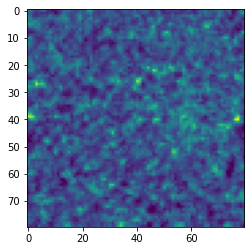

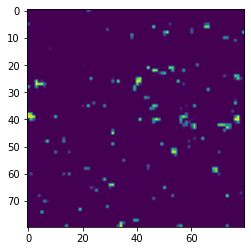

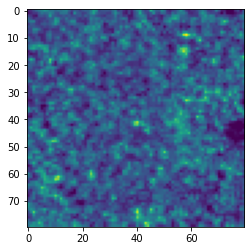

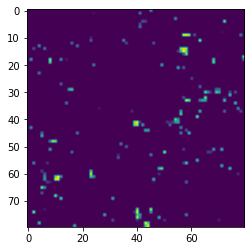

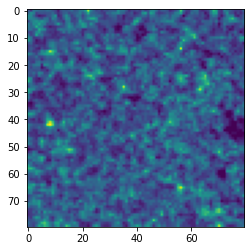

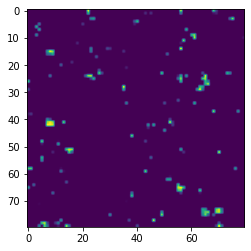

Slice 2 Loc 1


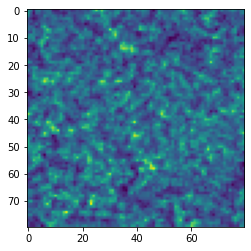

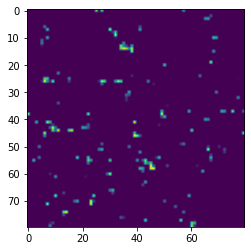

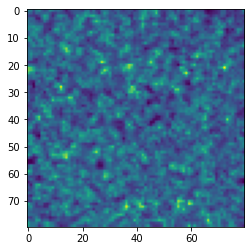

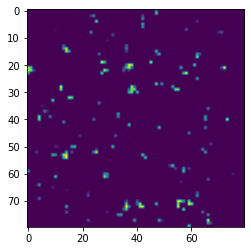

Slice 3 Loc 1
Slice 4 Loc 1


In [7]:
# Instead of GMM, we replace with contrast normalization processing:
#    1) stratify into fairly-wide SNR strata (introduces SNR cutoff)
#    2) each strata is contrast-normalized via histogram equalization (https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html)
#    3) SNR cutoff is again applied to each contrast-normalized strata
#    4) continue with processing (size cutoffs, trace sifting, electrode occlusion)

# single_images structure:
# single_images[slic][loc][image_type] = dic_image 2-D array
#    where image_type is ['e', 'f', 'i'] for electrode, fluorescent, or image
# single_images[slic][loc][map_type][rec] = dat_image 2-D array
#    where map_type is ['Amp', 'SNR', 'Nos'] for amplitude, SNR< or no-stim SNR
# single_images[slic][loc]['stims'] = [stim list indexed by rec #]

n_plots = 5
use_clahe = False  # if false, use custom SSAHE (recommended)
absolute_cutoff = 97
strata_widths = 0.05
percentile_strata = [ [absolute_cutoff + i * strata_widths, 
                       absolute_cutoff + (i+1) * strata_widths] 
                     for i in range(0, int((100-absolute_cutoff) / strata_widths)) ]
if quick_test:
    percentile_strata = [ percentile_strata[-1] ]

for slic in single_images:
    for loc in single_images[slic]:
        print("Slice", slic, "Loc", loc)
        for rec in single_images[slic][loc]['SNR']:
            
            if (process_all or (slic in slice_target and rec in rec_target)) and restore_pickle is None:
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w = snr.shape[0]
                    
                # scale to 16-bit integers
                snr_scaled = ((snr - snr.min()) * (1/(snr.max() - snr.min()) * 65535)).astype('uint32')
                
                # CLAHE option
                if use_clahe:
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                    contrast_normed_snr = clahe.apply(np.uint16(snr_scaled))
            
                # SNR-stratified histogram equalization option
                else:
                    contrast_normed_snr = cnorm.contrast_norm(snr_scaled, percentile_strata)
                
                if n_plots > 0:
                    plt.clf()
                    plt.imshow(snr)
                    plt.show()
                    plt.clf()
                    plt.imshow(contrast_normed_snr)
                    plt.show()
                    n_plots -= 1

                # turn the contrast normed SNR into clusters
                all_pixels = np.transpose((contrast_normed_snr != 0).nonzero())
                all_pixels = np.flip(all_pixels, 1)
                all_pixels = all_pixels.tolist()
                cluster_objs = []
                clus = Cluster(all_pixels, w)
                cluster_objs = clus.attempt_split()
                cluster_objs.append(clus)

                single_images[slic][loc]['SNR'][rec]['clusters'] = cluster_objs

In [8]:
# save/load point: pickle all objects to "last run" in current working directory. Also loads if restore_pickle is True
Pickler(dir_base, date, save_pickle_index, restore_pickle, slice_target[0]).process_pickle(single_images)

Wrote: C:/Users/jjudge3/Desktop/Data/10-14-22/saved_run5-1.pickle


In [9]:
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            print(slic, loc, rec)
            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                
                # Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
                if 'pixel_roi_occurrence_map' not in single_images[slic][loc]:
                    single_images[slic][loc]['pixel_roi_occurrence_map'] = np.zeros(snr.shape)
                    
                w, h = snr.shape
                clusters = single_images[slic][loc]['SNR'][rec]['clusters']

                # Split non-contiguous clusters until contiguous
                extra_clusters = []
                for cluster in clusters:
                    new_clusters = cluster.attempt_split()
                    extra_clusters += new_clusters
                clusters += extra_clusters
                
                # Filter clusters by size
                for i in range(len(clusters)-1, -1, -1):  # strata 1 is the lower-SNR strata
                    if clusters[i].get_cluster_size() > n_pixel_cutoff:
                        del clusters[i]

                # filter adjacent (touching) clusters of different clusters -- remove the lower-SNR one. 
                """for i in range(len(cluster_strata)):
                    stratum1 = cluster_strata[i]
                    for j in range(i+1, len(cluster_strata)):
                        stratum2 = cluster_strata[j]
                        for ic_1 in range(len(stratum1)-1, -1, -1):  # stratum 1 is the lower-SNR stratum
                            for c2 in stratum2:
                                if stratum1[ic_1].is_adjacent_to(c2):
                                    del stratum1[ic_1]
                                    break"""
                                    
                print("# clusters:", len(clusters))
                # Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
                for cluster in clusters:
                    for px in cluster.get_pixels():
                        y, x = px
                        single_images[slic][loc]['pixel_roi_occurrence_map'][x, y] += 1


1 1 1
# clusters: 67
1 1 2
# clusters: 79
1 1 3
# clusters: 66
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
2 1 1
# clusters: 74
2 1 2
# clusters: 76
2 1 3
# clusters: 61
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
3 1 1
# clusters: 53
3 1 2
# clusters: 62
3 1 3
# clusters: 74
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13
3 1 14
3 1 15
3 1 16
3 1 17
4 1 1
# clusters: 91
4 1 2
# clusters: 82
4 1 3
# clusters: 78
4 1 4
4 1 5
4 1 6
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
4 1 17


1 1 1
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR01_01_01.dat
7


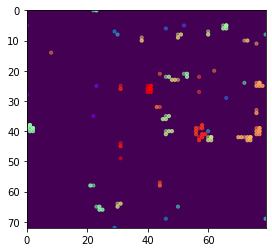

1 1 2
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR01_01_02.dat
8


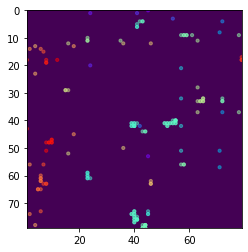

1 1 3
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR01_01_03.dat
7


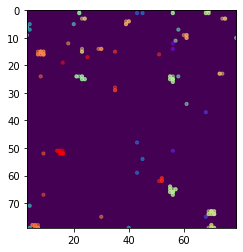

1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
2 1 1
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR02_01_01.dat
9


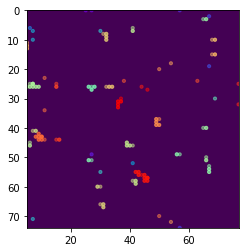

2 1 2
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR02_01_02.dat
7


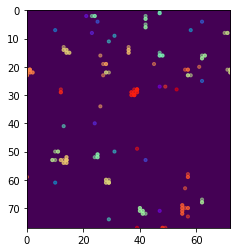

2 1 3
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR02_01_03.dat
10


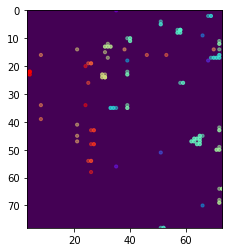

2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
3 1 1
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR03_01_01.dat
6


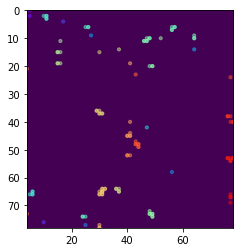

3 1 2
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR03_01_02.dat
8


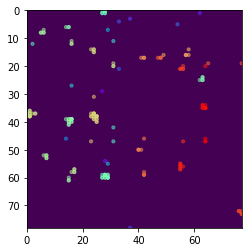

3 1 3
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR03_01_03.dat
5


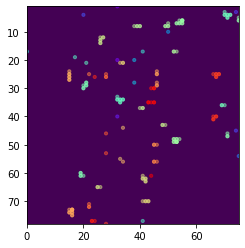

3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13
3 1 14
3 1 15
3 1 16
3 1 17
4 1 1
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR04_01_01.dat
7


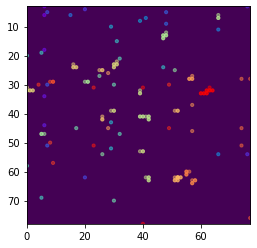

4 1 2
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR04_01_02.dat
6


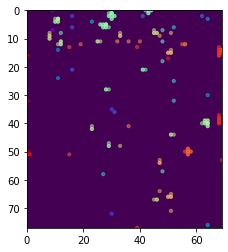

4 1 3
No RLI image to lay over
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-highest-SNR04_01_03.dat
6


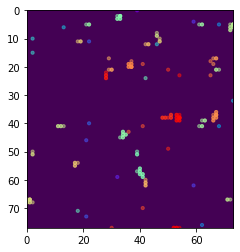

4 1 4
4 1 5
4 1 6
4 1 8
4 1 9
4 1 10
4 1 11
4 1 12
4 1 13
4 1 14
4 1 15
4 1 16
4 1 17


In [10]:
# consolidating, plotting, and writing to disk
for slic in single_images:
    for loc in single_images[slic]:
        for rec in single_images[slic][loc]['SNR']:
            print(slic, loc, rec)

            if process_all or (slic in slice_target and rec in rec_target):
                
                snr = single_images[slic][loc]['SNR'][rec]['data']
                w, h = snr.shape
                clusters = single_images[slic][loc]['SNR'][rec]['clusters']
                                                    
                # consolidate strata and show all surviving ROIs
                plt.clf()
                j_label = 0

                if len(clusters) > 0:
                    pixels = []
                    labels = []
                    for c in clusters:
                        new_pixels = c.get_pixels()
                        pixels += new_pixels
                        labels += [j_label for _ in range(len(new_pixels))]
                        j_label += 1
                    pixels = np.array(pixels)
                    rli_image = None
                    try:
                        rli_image = single_images[slic][loc]['RLI'][rec]['data']
                    except Exception as e:
                        print("No RLI image to lay over")
                    roi.draw_gmm_enclosures(pixels, labels, a=0.5, s=10, 
                                            show=False, 
                                            plot_sample_heatmap=False,
                                            overlay_image=rli_image)
                    filename = dat_dir + "ROIs-highest" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                    roi_write = ROIFileWriter()

                    # export only the highest SNR clusters.
                    regions = roi_write.export_clusters(filename, labels, pixels, w, 
                                                        limit=num_regions_to_export,
                                                        snr=snr)

                    # Export ROIs to ImageZ format for region drawing
                    all_px_regions = roi_write.get_regions_by_pixel()
                    filename = dat_dir + "ImageZ" + "-" + single_images[slic][loc]['SNR'][rec]['filename']
                    filename = filename[:-4] + ".tsv"
                    reg_exp.export(filename, all_px_regions)

                    single_images[slic][loc]['SNR'][rec]['final_ROIs'] = all_px_regions
                    single_images[slic][loc]['SNR'][rec]['final_ROIs_filename'] = filename
                    
                plt.show()

In [11]:
# Now load in the trace*.dat files that PhotoZ/OrchestraZ has written
tr = Tracer()
plot_threshold = 999990
trace_metric = ['snr', 'df/f'][0] # select index

metric_dist = {}
enable_trace_sifter_training = False
load_trace_sifter_model = False
if load_trace_sifter_model:
    enable_trace_sifter_training = False
trace_sifter_features = {
    'trace_data': [],
    'roi_names': [],
    'values': []
}
dff_div_factor = 1000.0 / 100.0 # 1000 factor for PhotoZ scaling issue, but * 100 to convert to %

interval = cam_settings['interval_between_samples']
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") \
        and filename[:3] != "ROI" \
        and filename.startswith("traces") \
        and "highest" in filename:
            
            traces = TracesDAT(dat_dir + filename).get_data()
            rec_id = filename.split(".")[0].split("-")[-1][3:]
            slice_loc_id = rec_id[:5]
            if slice_loc_id not in metric_dist:
                metric_dist[slice_loc_id] = []
            mx, my = measure_window
            for roi_name in traces:
                
                # calculate METRIC
                value = None
                meas = traces[roi_name][mx:my]
                pre_stim = traces[roi_name][10:stim_times-5]
                maxx = np.max(meas)
                
                # calculate SNR
                sd = np.std(pre_stim)
                snr = maxx / sd
                metric_dist[slice_loc_id].append(snr)
                value = snr
                if snr > plot_threshold:
                    tr.plot_roi_trace(traces[roi_name], 
                                      interval,
                                      rec_id + ": " + roi_name,
                                      stim_time=stim_times,
                                      measure_window=measure_window,
                                      value=snr,
                                      metric_name=trace_metric)

                # calculate df/f
                dff = tr.calculate_dff(traces[roi_name], stim_times, measure_window, roi_name) / dff_div_factor
                if trace_metric == 'df/f':
                    dff = value
                    metric_dist[slice_loc_id].append(value)
                if dff > plot_threshold:
                    tr.plot_roi_trace(traces[roi_name], 
                                      interval,
                                      rec_id + ": " + roi_name,
                                      stim_time=stim_times,
                                      measure_window=measure_window,
                                      value=dff,
                                      metric_name=trace_metric)
                    
                # store DATA if going to use for accept/reject
                if enable_trace_sifter_training:
                    trace_sifter_features['trace_data'].append(traces[roi_name])
                    trace_sifter_features['roi_names'].append(rec_id + ": " + roi_name)
                    trace_sifter_features['values'].append(value)
                    trace_sifter_features['dff'].append(dff)
                    trace_sifter_features['snr'].append(snr)

In [12]:
accepted = None
trace_sifter_model = TraceLearner()
trace_data = np.array(trace_sifter_features['trace_data'])
if enable_trace_sifter_training:
    print(trace_data.shape)
    plt.clf()
    ts = TraceSifter(trace_data,
                    cam_settings['interval_between_samples'],
                    trace_sifter_features['roi_names'],
                    stim_time=stim_times,
                    measure_window=measure_window,
                    values=trace_sifter_features['values'],
                    metric_name=trace_metric)
    accepted = ts.present_accept_reject()
    
    # train model using trace data + accepted labels
    trace_sifter_model.load_model()
    trace_sifter_model.add_examples(trace_data, accepted)
    trace_sifter_model.train_model()
    trace_sifter_model.save_model()

# use stored trace sifter model to discard
if load_trace_sifter_model and not enable_trace_sifter_training:
    trace_sifter_model.load_model()
    accepted = trace_sifter_model.predict_labels(trace_data)

if accepted is not None:
    # discard traces/ROIs that user did not select
    pass
    # remember to also update trace_sifter_features['values'], 'dff', and 'snr' for later use.


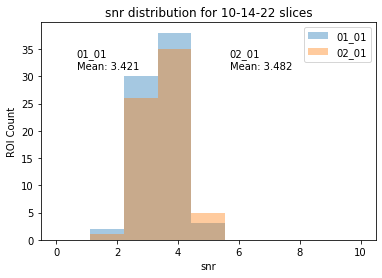

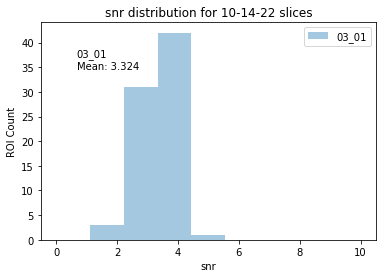

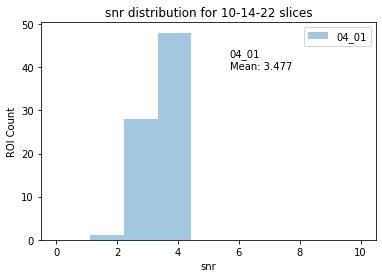

| Date  | Slice/Loc |  Mean snr | Number ROIs | Line | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| 10-14-22 | 01_01 | 3.421 | 73 | kv2.1hVOS 3.0 / PV-Cre | 
| 10-14-22 | 02_01 | 3.482 | 67 | kv2.1hVOS 3.0 / PV-Cre | 
| 10-14-22 | 03_01 | 3.324 | 77 | kv2.1hVOS 3.0 / PV-Cre | 
| 10-14-22 | 04_01 | 3.477 | 77 | kv2.1hVOS 3.0 / PV-Cre | 

Average snr (weighted by # ROIs): 3.424665
Total ROI count: 294


In [13]:
# Plot TRACE_METRIC distributions for each slice/loc
i = 0
labels = []
for sl_id in metric_dist:
    
    plt.hist(metric_dist[sl_id], 
             np.linspace(0,10,10), 
             alpha=0.4, 
             label=sl_id)
    # mode = stats.mode([int(np.round(x)) for x in metric_dist[sl_id]])[0][0]
    plt.annotate(sl_id +
               "\nMean: " + str(np.average(metric_dist[sl_id]))[:5],
    #         + "\nMode: " + str(mode),
               (0.2 + (i%2) * 0.4, 0.75),
                xycoords='figure fraction')
    labels.append(sl_id)
    i += 1
    if i % 2 == 0 or i >= len(metric_dist.keys()) - 1:
        plt.legend(labels)
        plt.title(trace_metric + " distribution for " + date + " slices")
        plt.xlabel(trace_metric)
        plt.ylabel("ROI Count")
        plt.show()
        labels = []
        
print("| Date  | Slice/Loc |  Mean " + trace_metric +" | Number ROIs | Line | ")
print("| ------------- | ------------- | ------------- | ------------- | ------------- |")
metric_roi_ct_products = 0
total_roi_ct = 0

for sl_id in metric_dist:
    met_val = np.average(metric_dist[sl_id])
    roi_ct = len(metric_dist[sl_id])
    metric_roi_ct_products += met_val * roi_ct
    total_roi_ct += roi_ct
    print("| " + date + " | " +
                sl_id + " | " +
                str(met_val)[:5] + 
                " | " + str(roi_ct) + " | " + str(cre_line_type) + " | ")

print("\nAverage " + trace_metric + " (weighted by # ROIs):", str(metric_roi_ct_products / total_roi_ct)[:8] )
print("Total ROI count:", total_roi_ct)



 ### Slice 1 Loc 1 ROI Occurrence heatmap (10-14-22)


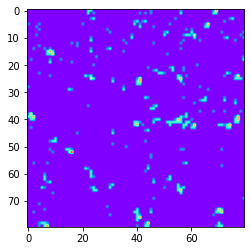

Max occurrences: 5.0
| Pixel | Occurrences | % Occurred |
  | ---- | ---- | ---- |
40 55  |   4.0  |  23.52%
16 9  |   4.0  |  23.52%
76 41  |   4.0  |  23.52%
15 8  |   4.0  |  23.52%
5 66  |   4.0  |  23.52%
40 77  |   4.0  |  23.52%
66 56  |   4.0  |  23.52%
79 7  |   4.0  |  23.52%
39 2  |   4.0  |  23.52%
52 16  |   5.0  |  29.41%
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-persistent1-1.dat


 ### Slice 2 Loc 1 ROI Occurrence heatmap (10-14-22)


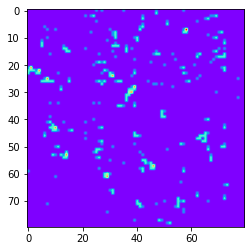

Max occurrences: 5.0
| Pixel | Occurrences | % Occurred |
  | ---- | ---- | ---- |
22 4  |   4.0  |  26.66%
43 10  |   4.0  |  26.66%
30 38  |   4.0  |  26.66%
57 46  |   4.0  |  26.66%
21 1  |   4.0  |  26.66%
28 39  |   4.0  |  26.66%
53 14  |   4.0  |  26.66%
25 7  |   4.0  |  26.66%
61 29  |   4.0  |  26.66%
7 58  |   5.0  |  33.33%
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-persistent2-1.dat


 ### Slice 3 Loc 1 ROI Occurrence heatmap (10-14-22)


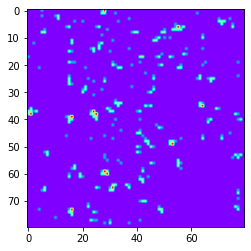

Max occurrences: 4.0
| Pixel | Occurrences | % Occurred |
  | ---- | ---- | ---- |
60 29  |   4.0  |  23.52%
65 31  |   4.0  |  23.52%
73 16  |   4.0  |  23.52%
35 64  |   4.0  |  23.52%
49 53  |   4.0  |  23.52%
39 16  |   4.0  |  23.52%
37 24  |   4.0  |  23.52%
6 55  |   4.0  |  23.52%
38 1  |   4.0  |  23.52%
38 25  |   4.0  |  23.52%
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-persistent3-1.dat


 ### Slice 4 Loc 1 ROI Occurrence heatmap (10-14-22)


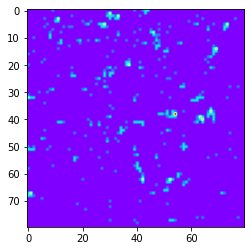

Max occurrences: 6.0
| Pixel | Occurrences | % Occurred |
  | ---- | ---- | ---- |
62 42  |   4.0  |  25.0%
14 69  |   4.0  |  25.0%
62 52  |   4.0  |  25.0%
5 28  |   4.0  |  25.0%
67 1  |   4.0  |  25.0%
39 63  |   4.0  |  25.0%
20 37  |   4.0  |  25.0%
3 11  |   4.0  |  25.0%
5 73  |   4.0  |  25.0%
38 54  |   6.0  |  37.5%
Regions written to: C:/Users/jjudge3/Desktop/Data/10-14-22/converted_zda/ROIs-persistent4-1.dat


In [14]:
# Now we conduct LTP study on the highest occurring pixels for each slic/loc

# First, Which pixels occur in a lot of ROIs? Generate a heatmap of occurrence counts
for slic in single_images:
    for loc in single_images[slic]:
        
        if 'pixel_roi_occurrence_map' in single_images[slic][loc]:
            
            snr = single_images[slic][loc]['SNR'][1]['data']
            w, h = snr.shape
            
            occ_map = single_images[slic][loc]['pixel_roi_occurrence_map']
            print("\n\n ###", "Slice", slic, "Loc", loc, "ROI Occurrence heatmap (" + date + ")")
            plt.imshow(occ_map, cmap="rainbow")
            plt.show()
            print("Max occurrences:", np.max(occ_map))
            # Give the pixel locations of the 10 highest occurrence pixels.
            max_occurrence_pixels = np.array(np.unravel_index(np.argsort(occ_map.ravel())[-10:], occ_map.shape))
            single_images[slic][loc]['max_occurrence_pixels'] = max_occurrence_pixels
            
            n_rec = len(single_images[slic][loc]['SNR'].keys())
            print("| Pixel | Occurrences | % Occurred |\n  | ---- | ---- | ---- |")
            for i in range(max_occurrence_pixels.shape[1]):
                y, x = max_occurrence_pixels[0, i], max_occurrence_pixels[1, i]
                print(y, x, " |  ", occ_map[y, x], " | ",  str(occ_map[y, x] / n_rec * 100.0)[:5]+ "%")
                
            # We need to write the new pixel ROIs to file and export them AGAIN from PhotoZ.
            filename = dat_dir + "ROIs-persistent" + str(slic) + "-" + str(loc) + ".dat"
            roi_write = ROIFileWriter()
            pixels = np.swapaxes(max_occurrence_pixels, axis1=0, axis2=1)
            labels = [1 for _ in range(1, 10)]  # arbitrary label, all in one cluster for now
            regions = roi_write.export_clusters(filename, labels, pixels, w, snr=snr)


traces_ROIs-persistent1-1-1.dat
traces_ROIs-persistent1-1-10.dat
traces_ROIs-persistent1-1-11.dat
traces_ROIs-persistent1-1-12.dat
traces_ROIs-persistent1-1-13.dat
traces_ROIs-persistent1-1-14.dat
traces_ROIs-persistent1-1-15.dat
traces_ROIs-persistent1-1-16.dat
traces_ROIs-persistent1-1-17.dat
traces_ROIs-persistent1-1-2.dat
traces_ROIs-persistent1-1-3.dat
traces_ROIs-persistent1-1-4.dat
traces_ROIs-persistent1-1-5.dat
traces_ROIs-persistent1-1-6.dat
traces_ROIs-persistent1-1-9.dat
traces_ROIs-persistent2-1-1.dat
traces_ROIs-persistent2-1-10.dat
traces_ROIs-persistent2-1-11.dat
traces_ROIs-persistent2-1-12.dat
traces_ROIs-persistent2-1-13.dat
traces_ROIs-persistent2-1-14.dat
traces_ROIs-persistent2-1-15.dat
traces_ROIs-persistent2-1-2.dat
traces_ROIs-persistent2-1-3.dat
traces_ROIs-persistent2-1-4.dat
traces_ROIs-persistent2-1-5.dat
traces_ROIs-persistent2-1-6.dat
traces_ROIs-persistent2-1-9.dat
traces_ROIs-persistent3-1-1.dat
traces_ROIs-persistent3-1-10.dat
traces_ROIs-persistent3-1

No handles with labels found to put in legend.



traces_ROIs-persistent3-1-2.dat
traces_ROIs-persistent3-1-3.dat
traces_ROIs-persistent3-1-4.dat
traces_ROIs-persistent3-1-5.dat
traces_ROIs-persistent3-1-6.dat
traces_ROIs-persistent3-1-9.dat
traces_ROIs-persistent4-1-1.dat
traces_ROIs-persistent4-1-10.dat
traces_ROIs-persistent4-1-11.dat
traces_ROIs-persistent4-1-12.dat
traces_ROIs-persistent4-1-13.dat
traces_ROIs-persistent4-1-14.dat
traces_ROIs-persistent4-1-15.dat
traces_ROIs-persistent4-1-16.dat
traces_ROIs-persistent4-1-17.dat
traces_ROIs-persistent4-1-2.dat
traces_ROIs-persistent4-1-3.dat
traces_ROIs-persistent4-1-4.dat
traces_ROIs-persistent4-1-5.dat
traces_ROIs-persistent4-1-6.dat
traces_ROIs-persistent4-1-9.dat
No TBS time possible for this slice/loc; 5 is not in list


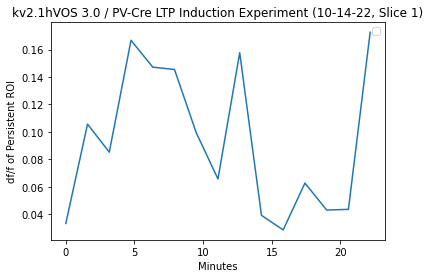

No handles with labels found to put in legend.


No TBS time possible for this slice/loc; 5 is not in list


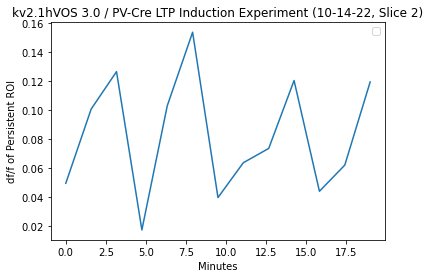

No handles with labels found to put in legend.


No TBS time possible for this slice/loc; 5 is not in list


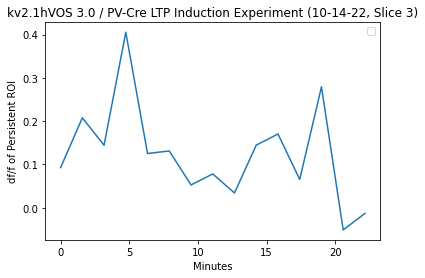

No handles with labels found to put in legend.


No TBS time possible for this slice/loc; 5 is not in list


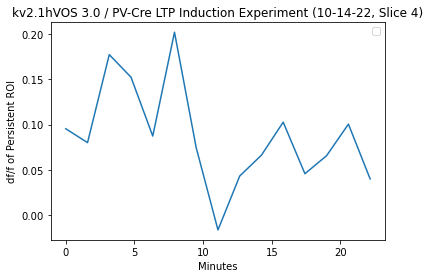

In [15]:
# Ok, you exported all the "persistent" ROI traces from PhotoZ
# Now we load them in and make LTP time courses of df/f

tr = Tracer()
plot_threshold = 99999999.5
trace_metric = ['snr', 'df/f'][1] # select index

dff_div_factor = 1000.0 / 100.0 # 1000 factor for PhotoZ scaling issue, but * 100 to convert to %
metric_dist = {}


interval = cam_settings['interval_between_samples']
for filename in os.listdir(dat_dir):
    if filename.endswith(".dat") \
        and filename[:3] != "ROI" \
        and filename.startswith("traces") \
        and "persistent" in filename:
            print(filename)
            
            traces = TracesDAT(dat_dir + filename).get_data()
            slice_loc_id = filename.split(".")[0].split("tent")[1]
            if len(slice_loc_id) < 4:
                continue
            slic, loc, rec = [int(x) for x in slice_loc_id.split("-")]
            if slic not in metric_dist:
                metric_dist[slic] = {}
            if loc not in metric_dist[slic]:
                metric_dist[slic][loc] = {}
                
            mx, my = measure_window
            for roi_name in traces:
                
                # calculate METRIC
                meas = traces[roi_name][mx:my]
                pre_stim = traces[roi_name][10:stim_times-5]
                maxx = np.max(meas)
                
                # calculate SNR
                if trace_metric == 'snr':
                    sd = np.std(pre_stim)
                    snr = maxx / sd
                    metric_dist[slic][loc][rec] = snr
                    if snr > plot_threshold:
                        tr.plot_roi_trace(traces[roi_name], 
                                          interval,
                                          rec_id + ": " + roi_name,
                                          stim_time=stim_times,
                                          measure_window=measure_window,
                                          value=snr,
                                          metric_name=trace_metric)
                # calculate df/f
                elif trace_metric == 'df/f':
                    dff = tr.calculate_dff(traces[roi_name], stim_times, measure_window, roi_name) / dff_div_factor
                    metric_dist[slic][loc][rec] = dff
                    if dff > plot_threshold:
                        tr.plot_roi_trace(traces[roi_name], 
                                          interval,
                                          rec_id + ": " + roi_name,
                                          stim_time=stim_times,
                                          measure_window=measure_window,
                                          value=dff,
                                          metric_name=trace_metric)

for slic in metric_dist:
    for loc in metric_dist[slic]:
        rec_time_course = []
        for rec in metric_dist[slic][loc]:
            rec_time_course.append(metric_dist[slic][loc][rec])

        # time course for all recordings for this slice/loc
        plt.clf()
        times = [i * actual_int_recording / 60 for i in range(len(rec_time_course))]
        plt.plot(times, rec_time_course)

        # label TBS time
        try:
            i_tbs = rec_target.index(tbs_recording_no)
            t_tbs = times[i_tbs]
            plt.axvline(x = t_tbs, color = 'r', label = 'TBS')
        except Exception as e:
            print("No TBS time possible for this slice/loc;", e)

        plt.xlabel("Minutes")
        plt.ylabel(trace_metric + " of Persistent ROI")
        plt.title(cre_line_type + " LTP Induction Experiment (" + date + ", Slice " + str(slic) + ")" )
        plt.legend()
        plt.show()
                